In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg
import dask

In [2]:
from estimator import RFClassifier, relu, bp_weights_dft, random_feature_matrix
from data_fns import pure_sine_dft

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:45503 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


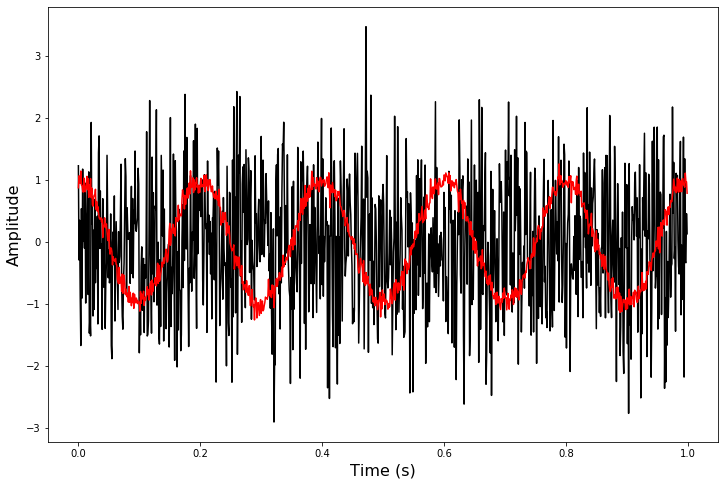

In [4]:
# data
fs = 1000
t = np.arange(0, 1, 1/fs)
A = scipy.linalg.dft(fs, scale=None)
x = A[:, 5].real + np.random.normal(0, 0.1, fs)
x_noise = np.random.normal(0, 1, fs)

fig = plt.figure(figsize=(12, 8))
plt.plot(t, x_noise, 'k')
plt.plot(t, x, 'r')
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.savefig('figures/lab_meeting/signal_noise.png')

In [5]:
# traditional random features
M, N = 5, fs
random_weights = random_feature_matrix(M, N, 'white noise').T
bp_weights = bp_weights_dft(M, N, 1, 5).T

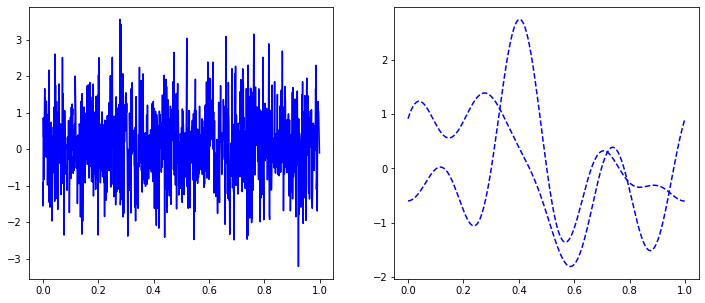

In [6]:
i = np.random.randint(M)
fig = plt.figure(figsize=(12, 5))
ax  = fig.add_subplot(121)
plt.plot(t, random_weights[i], 'b')

ax = fig.add_subplot(122)
plt.plot(t, bp_weights[i], '--b')
plt.plot(t, bp_weights[i - 1], '--b')
plt.savefig('figures/lab_meeting/feature_examples.png')

In [7]:
def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return 1 - clf.score(X_test, y_test)

In [16]:
# generate data
nPoints, fs, sig_dur = 5000, 1500, 0.1
k, a = 6, 0.8
X, y = pure_sine_dft(nPoints, fs, k, sig_dur, a, seed=20)

N = X.shape[1]
f_signal = int(k / sig_dur)
print('signal frequency=%d Hz' % f_signal)

# split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

signal frequency=60 Hz
[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


In [17]:
%%time
# classification
f_gaus = lambda M, N: bp_weights_dft(M, N, lowcut=k - 3, highcut=k + 3)
h = relu

weights = [('bandpass_dft', f_gaus), ('white noise', None)]
results = {wt:[] for (wt, func) in weights}
for n in n_features:
    for (wt, func) in weights:
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[wt].append(np.real(dask.compute(*lazy_results)))

CPU times: user 8.38 s, sys: 3.02 s, total: 11.4 s
Wall time: 44.3 s


In [18]:
mean_err_bp, std_err_bp = np.mean(results['bandpass_dft'], axis=1), np.std(results['bandpass_dft'], axis=1)
mean_err_wn, std_err_wn = np.mean(results['white noise'], axis=1), np.std(results['white noise'], axis=1)

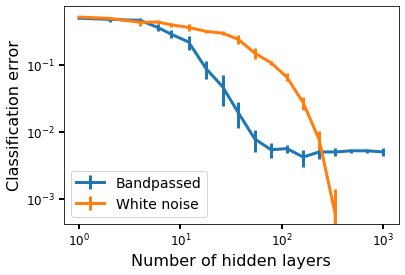

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(n_features, mean_err_bp, yerr=std_err_bp, fmt='-', label='Bandpassed',  markersize=4, lw=3)
ax.errorbar(n_features, mean_err_wn, yerr=std_err_wn, fmt='-', label='White noise',  
            markersize=4, lw=3)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Number of hidden layers', fontsize=16)
plt.ylabel('Classification error', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc = 'lower left', fontsize=14)

In [ ]:
mean_err_bp

In [ ]:
mean_err_wn